In [86]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable
import orthopy,quadpy

As a prime basis, we will start with the hexahedral basis from (Wheeler, Xue & Yotov, 2012) which has a dimension of 24.

In [78]:
def CreateTriangleLocations(n):
    u = np.linspace(-1,1,n)
    x,y = np.meshgrid(u,u)
    x = x.flatten(); y = y.flatten()
    ind = np.where(x<(-y)+2/n/10)
    return x[ind],y[ind]

def CreatePrismLocations(n):
    zp = np.linspace(-1,1,n)
    xp,yp = CreateTriangleLocations(n)
    x = xp[:,np.newaxis] * np.ones(zp.size)
    y = yp[:,np.newaxis] * np.ones(zp.size)
    z = np.ones(xp.shape)[:,np.newaxis] * zp
    return x.flatten(order='f'),y.flatten(order='f'),z.flatten(order='f')

In [79]:
def WheelerXueYotov(x,y,z):
    V = np.zeros((3,x.size,24))
    O = np.zeros(x.size)
    for d in range(3):
        V[d,:,4*d+0] = np.ones(x.size)
        V[d,:,4*d+1] = x
        V[d,:,4*d+2] = y
        V[d,:,4*d+3] = z
    i = 12
    V[...,i] = [     x*z,     -y*z,        O]; i+=1 # curl(0       ,0       ,x*y*z   )
    #V[...,i] = [   2*x*y,    -y**2,        O]; i+=1 # curl(0       ,0       ,x*y**2  )
    V[...,i] = [       O,   -2*x*z,        O]; i+=1 # curl(0       ,0       ,x**2*z  )
    #V[...,i] = [  x**2*z, -2*x*y*z,        O]; i+=1 # curl(0       ,0       ,x**2*y*z)
    V[...,i] = [       O,      x*y,     -x*z]; i+=1 # curl(x*y*z   ,0       ,0       )
    V[...,i] = [       O,    2*y*z,    -z**2]; i+=1 # curl(y*z**2  ,0       ,0       )
    V[...,i] = [       O,        O,   -2*x*y]; i+=1 # curl(x*y**2  ,0       ,0       )
    V[...,i] = [       O,   x*y**2, -2*x*y*z]; i+=1 # curl(x*y**2*z,0       ,0       )
    V[...,i] = [    -x*y,        O,      y*z]; i+=1 # curl(0       ,x*y*z   ,0       )
    V[...,i] = [   -x**2,        O,    2*x*z]; i+=1 # curl(0       ,x**2*z  ,0       )
    V[...,i] = [  -2*y*z,        O,        O]; i+=1 # curl(0       ,y*z**2  ,0       )
    V[...,i] = [-2*x*y*z,        O,   y*z**2]; i+=1 # curl(0       ,x*y*z**2,0       ) 
    return V[...,:i]

We will take this hexahedral space and constrain it like in (Kriby, 2004) to reduce the dimensionality to 18 (6 constraints) to suit the prism. First we setup contraint equations on the top and bottom faces to remove $xy$ terms from the normal components.

In [80]:
def IntegrateFace(Xc,orders,fcns):
    # example: all functions of the first 3 orders
    #   orders = [0,1,1,2,2,2]
    #   fcns   = [0,0,1,0,1,2]
    Xc = np.array(Xc)
    
    if Xc.shape[0] == 3:
        
        # triangle quadrature
        scheme = quadpy.triangle.seven_point()
        quad = scheme.points @ np.asarray([[-1,-1],[+1,-1],[-1,+1]]) # to cartesian
        xq,yq = quad[:,0],quad[:,1]; zq = np.ones(xq.shape)*Xc[0,2]
        wq = scheme.weights
        
        # prime space times outward normal
        P = WheelerXueYotov(xq,yq,zq)
        n = np.cross(Xc[1,:]-Xc[0,:],Xc[2,:]-Xc[0,:]); n = n/np.linalg.norm(n)
        p = P.T @ n 
        
        # compute moments
        bary = np.asarray([(xq+1)/2,(yq+1)/2,1-(xq+1)/2-(yq+1)/2])
        poly = orthopy.triangle.tree(bary,max(orders)+1,"normal")
        I = []
        for o,f in zip(orders,fcns):
            I.append((p*poly[o][f]*wq).sum(axis=1))
        I = np.array(I)

    elif Xc.shape[0] == 4:
        
        # tensor product quadrature
        x1d,w1d = np.polynomial.legendre.leggauss(3)
        x2d,y2d = np.meshgrid(x1d,x1d); x2d = x2d.flatten(); y2d = y2d.flatten()
        w2d = (w1d[:,np.newaxis]*w1d).flatten()
    
        # map 2d quadrature to 3d points on face
        N = 0.25*np.array([(1-x2d)*(1-y2d),
                           (1+x2d)*(1-y2d),
                           (1-x2d)*(1+y2d),
                           (1+x2d)*(1+y2d)])
        Xq = np.dot(Xc.T,N)
        xq  = Xq[0,:]; yq = Xq[1,:]; zq = Xq[2,:]
        dJ = np.linalg.norm(Xc[1,:]-Xc[0,:])*np.linalg.norm(Xc[2,:]-Xc[0,:])/4.0 # if planar

        # prime space times outward normal
        P = WheelerXueYotov(xq,yq,zq)
        n = np.cross(Xc[1,:]-Xc[0,:],Xc[2,:]-Xc[0,:]); n = n/np.linalg.norm(n)
        p = P.T @ n 
    
        # compute moments
        poly = orthopy.quadrilateral.tree(np.asarray([x2d,y2d]),max(orders)+1)
        I = []
        for o,f in zip(orders,fcns):
            I.append((p*poly[o][f]*w2d*dJ).sum(axis=1))
        I = np.array(I)
        
    return I

In [81]:
C =              IntegrateFace([[-1,-1,+1],
                                [+1,-1,+1],
                                [-1,+1,+1]],[2],[0]) # top
C = np.vstack([C,IntegrateFace([[+1,-1,-1],
                                [-1,-1,-1],
                                [-1,+1,-1]],[2],[0])]) # bottom
C = np.vstack([C,IntegrateFace([[+1,-1,-1],
                                [-1,+1,-1],
                                [+1,-1,+1],
                                [-1,+1,+1]],[2,3],[0,1])]) # diagonal

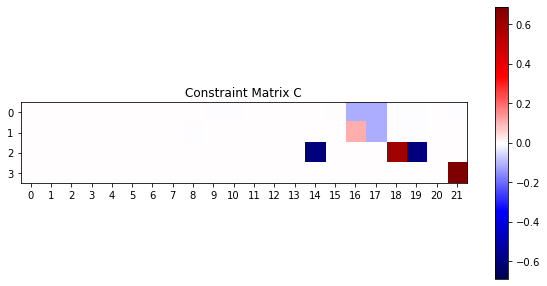

Singular values: [1.03279556 0.68853037 0.15396007 0.15396007]


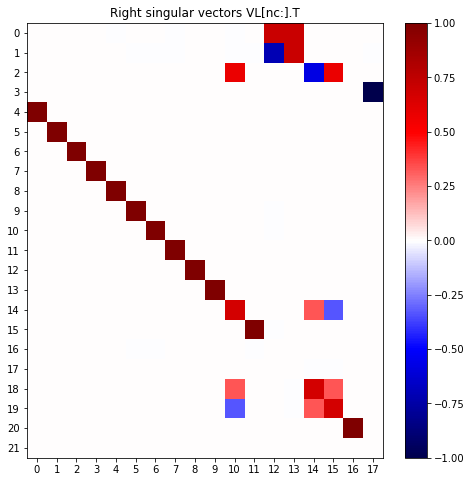

In [82]:
mag = np.abs(C).max()
fig,ax = plt.subplots(figsize=(10,5))
cb = ax.imshow(C,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.xlim(-0.5,C.shape[1]-0.5)
plt.xticks(range(C.shape[1]))
plt.yticks(range(C.shape[0]))
plt.title("Constraint Matrix C")
plt.show()

UL,SL,VL = np.linalg.svd(C)
print("Singular values:",SL)

VL = VL[C.shape[0]:,:]
mag = np.abs(VL).max()
fig,ax = plt.subplots(figsize=(8,8))
cb = ax.imshow(VL.T,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.xticks(range(VL.shape[0]))
plt.yticks(range(VL.shape[1]))
plt.title("Right singular vectors VL[nc:].T")

plt.show()

In [83]:
xn = np.zeros(18); yn = np.zeros(18); zn = np.zeros(18); n = np.zeros((18,3)); s = 1/np.sqrt(2)

# face x = -1
xn[0],yn[0],zn[0] = -1,-1,-1
xn[1],yn[1],zn[1] = -1,+1,-1
xn[2],yn[2],zn[2] = -1,-1,+1
xn[3],yn[3],zn[3] = -1,+1,+1
n[:4,0] = -1

# face y = -1
xn[4],yn[4],zn[4] = -1,-1,-1
xn[5],yn[5],zn[5] = +1,-1,-1
xn[6],yn[6],zn[6] = -1,-1,+1
xn[7],yn[7],zn[7] = +1,-1,+1
n[4:8,1] = -1

# face y = -x
xn[ 8],yn[ 8],zn[ 8] = +1,-1,-1
xn[ 9],yn[ 9],zn[ 9] = -1,+1,-1
xn[10],yn[10],zn[10] = +1,-1,+1
xn[11],yn[11],zn[11] = -1,+1,+1
n[8:12,:2] = s

# face z = -1
xn[12],yn[12],zn[12] = -1,-1,-1
xn[13],yn[13],zn[13] = +1,-1,-1
xn[14],yn[14],zn[14] = -1,+1,-1
n[12:15,2] = -1

# face z = +1
xn[15],yn[15],zn[15] = -1,-1,+1
xn[16],yn[16],zn[16] = +1,-1,+1
xn[17],yn[17],zn[17] = -1,+1,+1
n[15:18,2] = 1 

In [84]:
# reduced Vandermonde matrix
V  = np.einsum('dij,id->ij',WheelerXueYotov(xn,yn,zn),n) # prime basis at nodes dotted by normals
Vr = VL @ V.T # transform prime to reduced
print("Vandermonde matrix condition number = ",np.linalg.cond(Vr))

# generate a nodal basis for plotting
xp,yp,zp = CreatePrismLocations(31)
P = WheelerXueYotov(xp,yp,zp)
Pr = VL @ np.swapaxes(P,2,1)
Nr = np.linalg.inv(Vr) @ Pr
print(Nr.shape)

Vandermonde matrix condition number =  10.694328703622492
(3, 18, 15376)


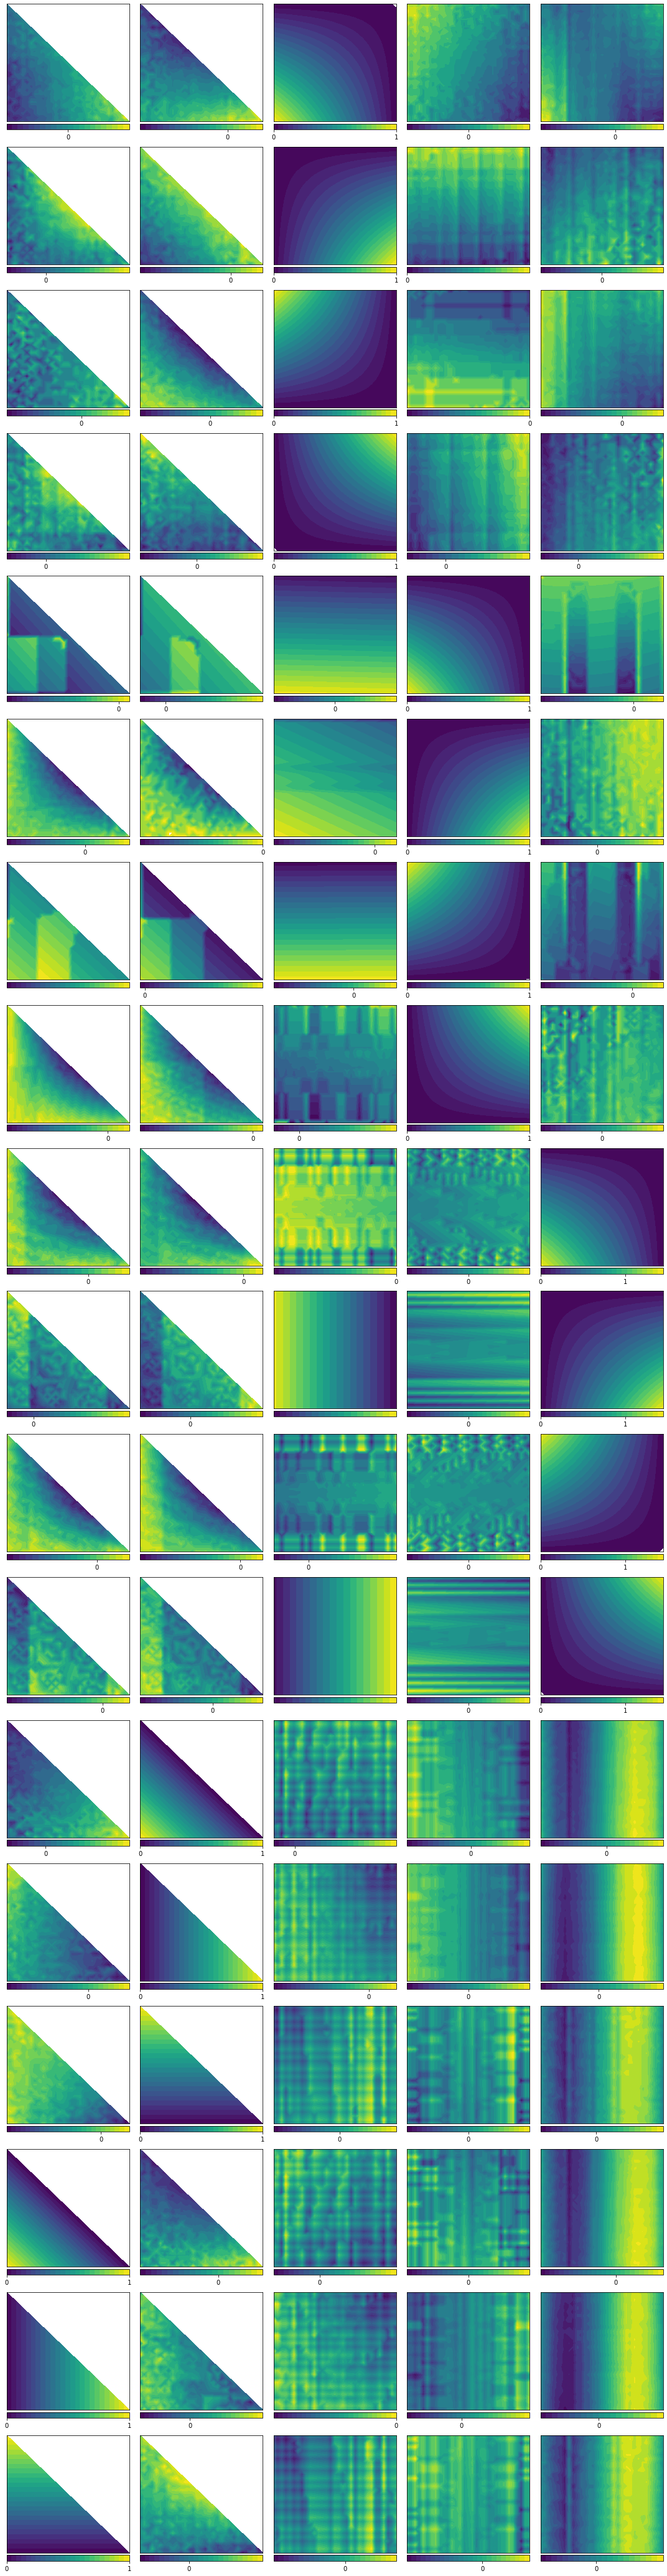

In [89]:
def PlotBasisPlane(condition,x,y,normal,basis,ax):
    ind = np.where(condition)[0]
    T = tri.Triangulation(x[ind],y[ind])
    data = normal @ basis[:,ind]
    p = ax.tricontourf(T,data,25)
    ax.set_xticks([]); ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom',size='5%',pad=0.05)
    plt.colorbar(p,cax=cax,ticks=[0,1],orientation='horizontal')
    
fig,ax = plt.subplots(nrows=Nr.shape[1],ncols=5,tight_layout=True,figsize=(15,3.2*Nr.shape[1]))
for i in range(Pr.shape[1]):
    PlotBasisPlane(np.abs(zp-(+1))<1e-3,xp,yp,[ 0, 0,+1],Nr[:,i,:],ax[i,0])
    PlotBasisPlane(np.abs(zp-(-1))<1e-3,xp,yp,[ 0, 0,-1],Nr[:,i,:],ax[i,1])
    PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,[-1, 0, 0],Nr[:,i,:],ax[i,2])
    PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,[ 0,-1, 0],Nr[:,i,:],ax[i,3])
    PlotBasisPlane(np.abs(xp+yp  )<1e-3,yp,zp,[+1,+1, 0],Nr[:,i,:],ax[i,4])